In [1]:
from pycaret.datasets import get_data
data = get_data('insurance')

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Experiment 1

In [2]:
from pycaret.regression import *

In [3]:
s = setup(data, target = 'charges', session_id = 123)

 
Setup Succesfully Completed.


,Description,Value
0,session_id,123
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(1338, 7)"
4,Missing Values,False
5,Numeric Features,2
6,Categorical Features,4
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [4]:
lrslim = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,4165.9659,33302027.1824,5770.7909,0.8011,0.4683,0.4153
1,4503.7366,43746480.7428,6614.1122,0.7456,0.5633,0.4217
2,3880.5528,31795139.4170,5638.7179,0.5974,0.7645,0.4396
3,3747.6457,26805298.3432,5177.3833,0.7762,0.5015,0.5175
4,4471.0419,43410532.5882,6588.6670,0.6771,0.5224,0.3767
5,4182.7551,36166332.0827,6013.8450,0.7674,0.7416,0.4320
6,4081.1022,39192588.2370,6260.3984,0.7333,0.6434,0.4241
7,4928.1534,46415035.8381,6812.8581,0.7448,0.5887,0.4137
8,4609.3147,40370354.9653,6353.7670,0.7392,0.5686,0.5111
9,4665.8647,42596794.8671,6526.6220,0.7256,0.8131,0.4802


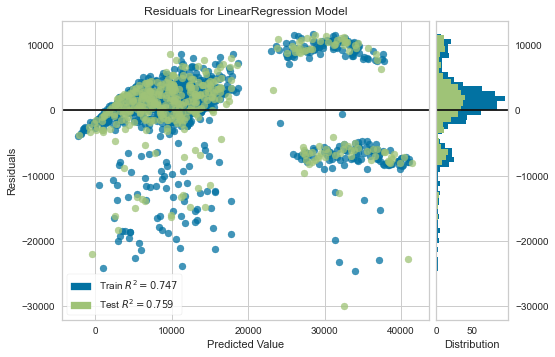

In [6]:
plot_model(lrslim)

# Experiment 2

In [ ]:
s2 = setup(data, target = 'charges', session_id = 123,
           normalize = True,
           polynomial_features = True, trigonometry_features = True, feature_interaction=True, 
           bin_numeric_features= ['age', 'bmi'])

In [ ]:
s2[0].columns

In [ ]:
lr = create_model('lr')

In [ ]:
plot_model(lr)

In [7]:
save_model(lrslim, 'deployment_slim8082020')

Transformation Pipeline and Model Succesfully Saved


In [10]:
deployment_slim8082020 = load_model('deployment_slim8082020')

Transformation Pipeline and Model Sucessfully Loaded


In [11]:
deployment_slim8082020

[Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       ml_usecase='regression',
                                       numerical_features=[], target='charges',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 numeric_strategy='mean',
                                 target_variable=None)),
                 ('new_levels1',
                  New_Catagorical_Levels...
                 ('group', Empty()), ('nonliner', Empty()), ('scaling', Empty()),
                 ('P_transform', Empty()), ('pt_target', Empty()),
                 ('binn', Empty()), ('rem_outliers', Empty()),
                 ('cluster_all', Empty()), ('dummy', Dummify(target='charges')),
                 (

In [ ]:
import requests
url = 'https://streamlit-blah.herokuapp.com/predict_api'
pred = requests.post(url,json={'age':55, 'sex':'male', 'bmi':59, 'children':1, 'smoker':'male', 'region':'northwest'})
print(pred.json())